In [253]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as geopd
import numpy as np
import seaborn as sns

In [254]:
data = pd.read_csv('data/Napoli.csv')

In [255]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7904 entries, 0 to 7903
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   COD_RIP                7904 non-null   int64  
 1   COD_REG                7904 non-null   int64  
 2   COD_PROV_STORICO       7904 non-null   int64  
 3   COD_UTS                7904 non-null   int64  
 4   PRO_COM_T              7904 non-null   int64  
 5   PRO_COM                7904 non-null   int64  
 6   COMUNE                 7903 non-null   object 
 7   COMUNE_IT              7903 non-null   object 
 8   COMUNE_A               124 non-null    object 
 9   DEN_RIP                7904 non-null   object 
 10  DEN_REG                7904 non-null   object 
 11  DEN_UTS                7904 non-null   object 
 12  TIPO_UTS               7904 non-null   int64  
 13  CC_REG                 7904 non-null   int64  
 14  CC_UTS                 7904 non-null   int64  
 15  SIGL

In [256]:
data = data[data['DEN_UTS'] == 'Napoli']
Napoli = data[[
    "COMUNE",
    "Latitudine",
    "Longitudine",
    "POP21",
    "FAM21",
    "SUPERFICIE"
]]


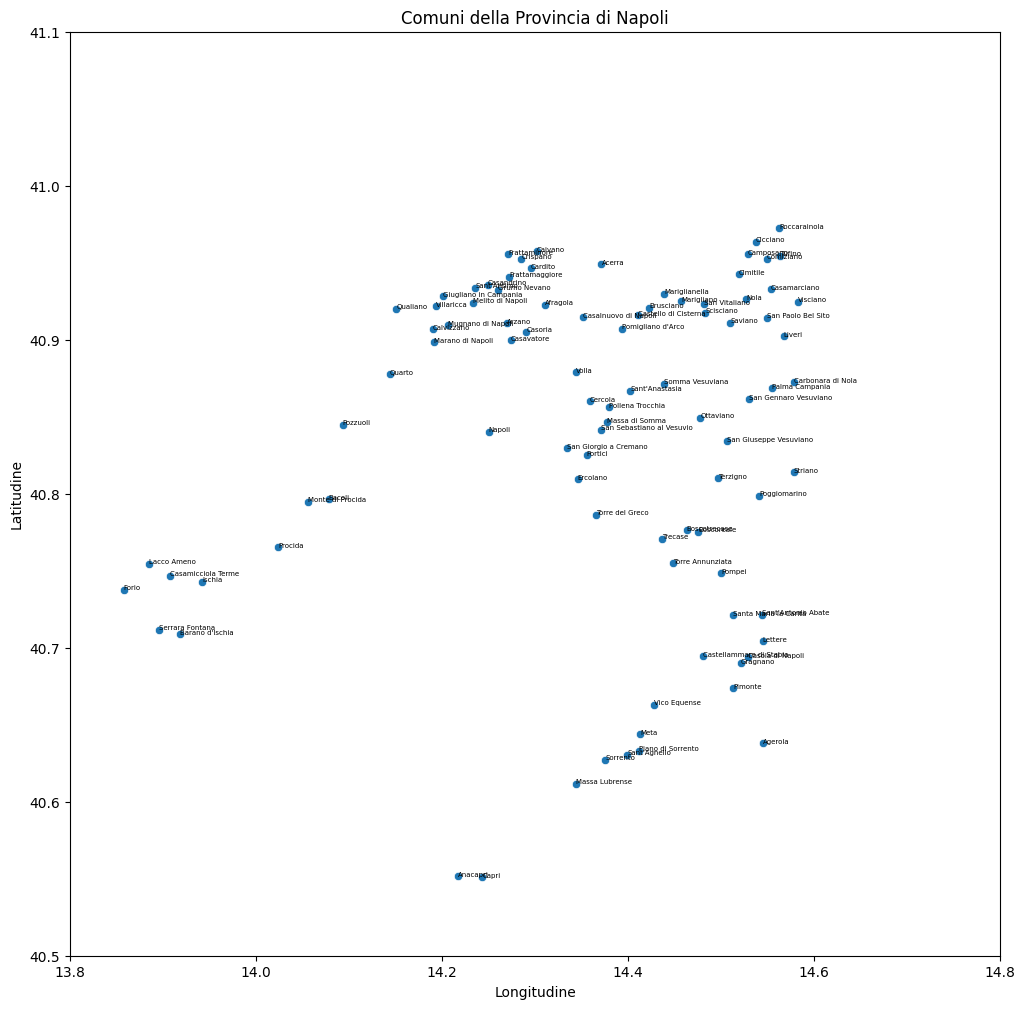

In [257]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.scatterplot(data=Napoli, y='Latitudine', x='Longitudine', ax=ax)

ax.set_xlim(13.8, 14.8) 
ax.set_ylim(40.5, 41.1)

for _, row in Napoli.iterrows():
    ax.text(row["Longitudine"], row["Latitudine"], row["COMUNE"], fontsize=5)

plt.title("Comuni della Provincia di Napoli")
plt.savefig('mappa_napoli.png', dpi=300, bbox_inches='tight')
plt.show()

In [258]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # raggio terrestre in metri

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c


lat = Napoli["Latitudine"].values
lon = Napoli["Longitudine"].values
n = len(lat)

dist_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        dist_matrix[i, j] = haversine(lat[i], lon[i], lat[j], lon[j])

distances = pd.DataFrame(dist_matrix, index=Napoli["COMUNE"], columns=Napoli["COMUNE"])


In [259]:
nomi_5 = Napoli['COMUNE'].iloc[:5].tolist()
matrice_5x5 = distances.iloc[:5, :5] / 1000 
df_estratto = pd.DataFrame(matrice_5x5.values, index=nomi_5, columns=nomi_5).round(2)

styled_table = df_estratto.style.background_gradient(cmap='Blues').format("{:.2f} km")
display(styled_table)

print("\n--- COPIA IL CODICE QUI SOTTO PER OVERLEAF ---")
print(df_estratto.to_latex())

plt.figure(figsize=(10, 8))
sns.heatmap(df_estratto, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'km'})
plt.title("Mappa di Calore delle Distanze (km)")
plt.savefig('matrice_calore.png', dpi=300, bbox_inches='tight')
plt.close()

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')

tabella_img = ax.table(cellText=df_estratto.values, 
                       colLabels=df_estratto.columns, 
                       rowLabels=df_estratto.index,
                       loc='center', 
                       cellLoc='center')

tabella_img.auto_set_font_size(False)
tabella_img.set_fontsize(12)
tabella_img.scale(1.2, 2.5)

for (row, col), cell in tabella_img.get_celld().items():
    if row == 0 or col == -1:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#2c3e50')
    else:
        cell.set_facecolor('#ecf0f1')

plt.savefig('matrice_distanze.png', dpi=300, bbox_inches='tight')
plt.close()


,Acerra,Afragola,Agerola,Anacapri,Arzano
Acerra,0.00 km,5.88 km,37.53 km,46.07 km,9.58 km
Afragola,5.88 km,0.00 km,37.31 km,42.03 km,3.72 km
Agerola,37.53 km,37.31 km,0.00 km,29.33 km,38.18 km
Anacapri,46.07 km,42.03 km,29.33 km,0.00 km,40.17 km
Arzano,9.58 km,3.72 km,38.18 km,40.17 km,0.00 km



--- COPIA IL CODICE QUI SOTTO PER OVERLEAF ---
\begin{tabular}{lrrrrr}
\toprule
 & Acerra & Afragola & Agerola & Anacapri & Arzano \\
\midrule
Acerra & 0.000000 & 5.880000 & 37.530000 & 46.070000 & 9.580000 \\
Afragola & 5.880000 & 0.000000 & 37.310000 & 42.030000 & 3.720000 \\
Agerola & 37.530000 & 37.310000 & 0.000000 & 29.330000 & 38.180000 \\
Anacapri & 46.070000 & 42.030000 & 29.330000 & 0.000000 & 40.170000 \\
Arzano & 9.580000 & 3.720000 & 38.180000 & 40.170000 & 0.000000 \\
\bottomrule
\end{tabular}



In [260]:
bins = [-1, 0, 15000, 30000, 45000, 65000]
labels = ["0","1", "2", "3", "4"]

dist_levels = pd.DataFrame(
    pd.cut(distances.values.flatten(), bins=bins, labels=labels)
    .reshape(distances.shape),
    index=distances.index,
    columns=distances.columns
)


In [261]:
Napoli['Domanda'] = Napoli['FAM21'] * 2 # media ordini in Italia

/var/folders/nf/0yfd5sbj61zggffg8w3y68th0000gn/T/ipykernel_71794/3894627491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Napoli['Domanda'] = Napoli['FAM21'] * 2 # media ordini in Italia


In [262]:
percentuali_di_compliance = {
    "0": 1,
    "1": 0.7,
    "2": 0.5,
    "3": 0.3,
    "4": 0.15,
    "5": 0.05
}

sconto da applicare sul ricavo unitario per utilizzo del servizio

In [263]:
sconto = {
    "0": 0,
    "1": 0.15,
    "2": 0.25,
    "3": 0.30,
    "4": 0.35,
    "5": 0.40,
}

In [264]:
ricavi = np.array([1, 1.25, 1.5, 1.75, 2])

domanda = Napoli['Domanda'].values.reshape(-1, 1)

# prodotto vettoriale: ogni colonna è domanda * ricavo
matrice_ricavi = domanda * ricavi


In [265]:
costi_fissi_e_operativi = 7500 + 0.85 * domanda

In [266]:
matrice_ricavi # dimensione = punto di domanda * lunghezza del vettore dei ricavi

array([[4.1384000e+04, 5.1730000e+04, 6.2076000e+04, 7.2422000e+04,
        8.2768000e+04],
       [4.4044000e+04, 5.5055000e+04, 6.6066000e+04, 7.7077000e+04,
        8.8088000e+04],
       [6.1380000e+03, 7.6725000e+03, 9.2070000e+03, 1.0741500e+04,
        1.2276000e+04],
       [5.3680000e+03, 6.7100000e+03, 8.0520000e+03, 9.3940000e+03,
        1.0736000e+04],
       [2.3210000e+04, 2.9012500e+04, 3.4815000e+04, 4.0617500e+04,
        4.6420000e+04],
       [2.0170000e+04, 2.5212500e+04, 3.0255000e+04, 3.5297500e+04,
        4.0340000e+04],
       [8.5220000e+03, 1.0652500e+04, 1.2783000e+04, 1.4913500e+04,
        1.7044000e+04],
       [1.9050000e+04, 2.3812500e+04, 2.8575000e+04, 3.3337500e+04,
        3.8100000e+04],
       [7.6980000e+03, 9.6225000e+03, 1.1547000e+04, 1.3471500e+04,
        1.5396000e+04],
       [1.1148000e+04, 1.3935000e+04, 1.6722000e+04, 1.9509000e+04,
        2.2296000e+04],
       [2.5078000e+04, 3.1347500e+04, 3.7617000e+04, 4.3886500e+04,
        5.01

In [267]:
# Insiemi
I = range(30)          # nodi i
U = range(6)        # livelli di distanza u = 0,...,m

     # costo fisso di installazione
# costo fisso per nodo i
f = {i: float(costi_fissi_e_operativi[i]) for i in I}  # costo fisso, unico per tutti i nodi

# domanda per nodo i
Q = {i: float(domanda[i]) for i in I}

# ricavi R come vettore per nodo i
R = 3

# sconti e percentuali di compliance
Cd = {int(k): float(v) for k, v in sconto.items()}
rho = {int(k): float(v) for k, v in percentuali_di_compliance.items()}

# Insiemi di copertura dei livelli
# S[i][u] = insieme dei nodi j nel livello u rispetto a i

S = {i: {u: [] for u in U} for i in I}

for i in I:
    for j in I:
        u = int(dist_levels.iloc[i, j])   # ← FIX
        S[i][u].append(j)

/var/folders/nf/0yfd5sbj61zggffg8w3y68th0000gn/T/ipykernel_71794/2052425456.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f = {i: float(costi_fissi_e_operativi[i]) for i in I}  # costo fisso, unico per tutti i nodi
/var/folders/nf/0yfd5sbj61zggffg8w3y68th0000gn/T/ipykernel_71794/2052425456.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q = {i: float(domanda[i]) for i in I}


In [268]:
model = gp.Model("Locker_Location_Multilevel")

In [269]:
x = model.addVars(I, vtype=GRB.BINARY, name="x")       # locker aperti
y = model.addVars(I, U, lb=0.0, name="y")             # frazione clienti assegnata
l = model.addVars(I, U, vtype=GRB.BINARY, name="l")   # indicatore livello aperto

In [270]:
model.setObjective(
    gp.quicksum(
        f[i] * x[i] 
        + Q[i]*gp.quicksum((R * Cd[u] - R)*rho[u]*y[i,u] for u in U)
        for i in I
    ),
    GRB.MINIMIZE
)



In [271]:
model.addConstrs(
    (y[i, u] <= l[i, u] for i in I for u in U),
    name="AssignmentConsistency"
)

{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 0): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (2, 0): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 2): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4): <gurobi.Constr *Awaiting Model Update*>,
 (2, 5): <gurobi.Constr *Awaiting Model Update*>,
 (3, 0): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,


In [272]:
model.addConstrs(
    (gp.quicksum(y[i, u] for u in U) == 1 for i in I),
    name="DemandCoverage"
)

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

In [273]:
model.addConstrs(
    (l[i, u] <= gp.quicksum(x[j] for j in S[i][u]) for i in I for u in U),
    name="LevelUpperBound"
)

{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 0): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (2, 0): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 2): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4): <gurobi.Constr *Awaiting Model Update*>,
 (2, 5): <gurobi.Constr *Awaiting Model Update*>,
 (3, 0): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,


In [274]:
model.addConstrs(
    (l[i, u] >= x[j] for i in I for u in U for j in S[i][u]),
    name="LevelLowerBound"
)

{(0, 0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 12): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 15): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 16): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 19): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 20): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 22): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 24): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 25): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 26): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 27): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 28): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1, 29): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2, 5): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2, 7): <gurobi.Constr *Await

In [275]:
model.optimize()

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1290 rows, 390 columns and 3420 nonzeros (Min)
Model fingerprint: 0xb294f73e
Model has 210 linear objective coefficients
Variable types: 180 continuous, 210 integer (210 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -293716.4950
Presolve removed 380 rows and 153 columns
Presolve time: 0.03s
Presolved: 910 rows, 237 columns, 2502 nonzeros
Variable types: 138 continuous, 99 integer (99 binary)

Root relaxation: objective -8.521581e+05, 104 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*

In [276]:
if model.status == GRB.OPTIMAL:
    open_lockers = [i for i in I if x[i].X > 0.5]
    print("Locker aperti nei nodi:", open_lockers)

    for i in I:
        for u in U:
            if y[i,u].X > 1e-6:
                print(f"Nodo {i} → livello {u}, quota clienti {y[i,u].X:.2f}")

Locker aperti nei nodi: [0, 1, 4, 5, 6, 7, 10, 13, 16, 22, 23]
Nodo 0 → livello 0, quota clienti 1.00
Nodo 1 → livello 0, quota clienti 1.00
Nodo 2 → livello 1, quota clienti 1.00
Nodo 3 → livello 1, quota clienti 1.00
Nodo 4 → livello 0, quota clienti 1.00
Nodo 5 → livello 0, quota clienti 1.00
Nodo 6 → livello 0, quota clienti 1.00
Nodo 7 → livello 0, quota clienti 1.00
Nodo 8 → livello 1, quota clienti 1.00
Nodo 9 → livello 1, quota clienti 1.00
Nodo 10 → livello 0, quota clienti 1.00
Nodo 11 → livello 1, quota clienti 1.00
Nodo 12 → livello 1, quota clienti 1.00
Nodo 13 → livello 0, quota clienti 1.00
Nodo 14 → livello 1, quota clienti 1.00
Nodo 15 → livello 1, quota clienti 1.00
Nodo 16 → livello 0, quota clienti 1.00
Nodo 17 → livello 2, quota clienti 1.00
Nodo 18 → livello 1, quota clienti 1.00
Nodo 19 → livello 1, quota clienti 1.00
Nodo 20 → livello 1, quota clienti 1.00
Nodo 21 → livello 1, quota clienti 1.00
Nodo 22 → livello 0, quota clienti 1.00
Nodo 23 → livello 0, quota 

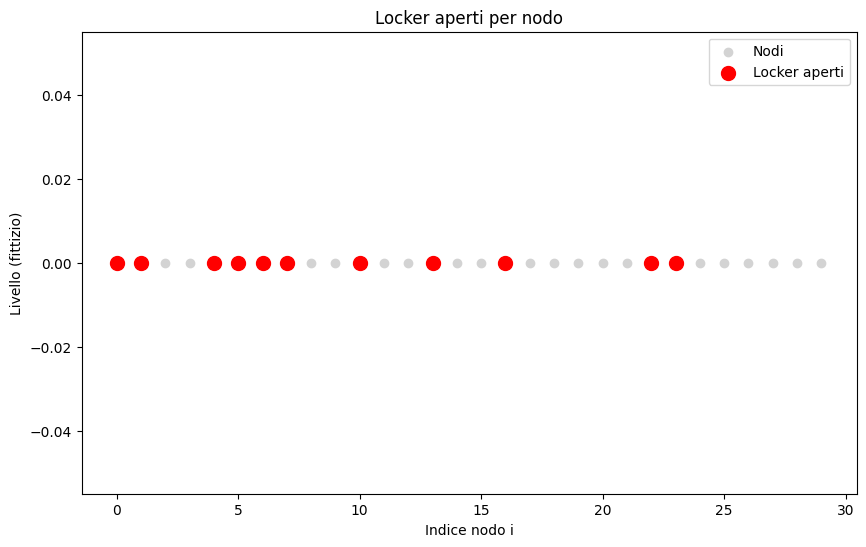

In [277]:
plt.figure(figsize=(10,6))

# Tutti i nodi come punti grigi
plt.scatter(range(len(I)), [0]*len(I), c='lightgray', label='Nodi')

# Locker aperti come punti rossi
open_lockers = [i for i in I if x[i].X > 0.5]
plt.scatter(open_lockers, [0]*len(open_lockers), c='red', label='Locker aperti', s=100)

plt.xlabel("Indice nodo i")
plt.ylabel("Livello (fittizio)")
plt.title("Locker aperti per nodo")
plt.legend()
plt.show()
